In [15]:
import numpy as np
from sklearn.datasets import fetch_olivetti_faces
import matplotlib.pyplot as plt
from scipy.linalg import eigh
import os


In [43]:
from PIL import Image
import os

folder = 'C:/Users/ALI/Desktop/EDFLA/coil-20-proc/' # replace this with the path to your image folder
cropped_folder = 'C:/Users/ALI/Desktop/EDFLA/cropped_images' # replace this with the path to the folder where you want to save the cropped images

if not os.path.exists(cropped_folder):
    os.makedirs(cropped_folder)

target_size = (32, 32)

for filename in os.listdir(folder):
    with Image.open(os.path.join(folder, filename)) as im:
        cropped_im = im.resize(target_size)
        cropped_im.save(os.path.join(cropped_folder, filename))


In [48]:
# Load all images into a list

img_path = 'C:/Users/ALI/Desktop/EDFLA/cropped_images/'
img_files = [img_path + f for f in os.listdir(img_path) if f.endswith('.png')]
img_data = [plt.imread(img_file).reshape(-1) for img_file in img_files]
img_data = np.array(img_data)

# Load the labels
n_classes = 20
n_samples_per_class = 72

img_labels = np.repeat(np.arange(n_classes), n_samples_per_class)

In [49]:
print(img_data.shape)
print(img_labels.shape)

(1440, 1024)
(1440,)


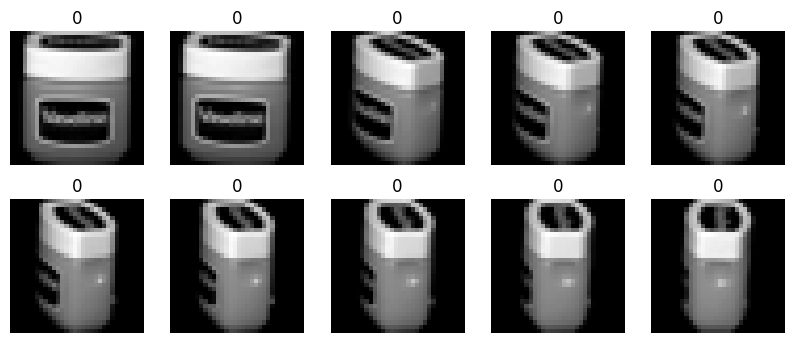

In [61]:
# plot the first 10 images
fig, ax = plt.subplots(2, 5, figsize=(10, 4))
for i in range(10):
    ax[i//5, i%5].imshow(img_data[i].reshape(32, 32), cmap='gray')
    ax[i//5, i%5].set_title(img_labels[i])
    ax[i//5, i%5].axis('off')
plt.show()


In [82]:
def EDFA(X, y):
    n, d = X.shape
    c = np.unique(y).shape[0]
    
    # compute the mean vectors for each class
    mean_vectors = []
    for class_ in range(c):
        mean_vectors.append(np.mean(X[y==class_], axis=0))
    
    # compute the scatter matrices
    Sb = np.zeros((d, d))
    Sw = np.zeros((d, d))
    for class_, mean_vec in enumerate(mean_vectors):
        n_samples = X[y==class_].shape[0]
        class_scatter = np.zeros((d, d))
        for row in X[y==class_]:
            row, mean_vec = row.reshape(d, 1), mean_vec.reshape(d, 1)
            class_scatter += (row - mean_vec).dot((row - mean_vec).T)
        Sw += class_scatter
        Sb += n_samples * (mean_vec - mean_vectors[0]).dot((mean_vec - mean_vectors[0]).T)
    
    # solve the eigenvalue problem
    eigenvalues, eigenvectors = eigh((Sb - Sw))
    eigenvectors = eigenvectors[:, np.argsort(eigenvalues)[::-1]]
    eigenvalues = eigenvalues[np.argsort(eigenvalues)[::-1]]

    # get 22 eigenvectors with the largest eigenvalues
    W = eigenvectors[:, :22]

    
    # transform the samples
    
    return W
    

In [64]:
def transform(X, W):
    Z = X.dot(W)
    return Z

In [87]:

def train_test(X, y):
    
    # Total number of samples per class
    samples_per_class = 72
    # Number of samples for training per class
    train_samples = 10

    # Load data
    all_data =X
    all_labels = y

    # Split data into training and testing sets
    X_train = []
    y_train = []
    X_test = []
    y_test = []

    for class_idx in np.unique(all_labels):
        class_data = all_data[all_labels == class_idx]
        train_indices = np.random.choice(samples_per_class, train_samples, replace=False)
        X_train.append(class_data[train_indices])
        y_train.append(np.full(train_samples, class_idx))
        X_test.append(np.delete(class_data, train_indices, axis=0))
        y_test.append(np.full(samples_per_class - train_samples, class_idx))

    X_train = np.concatenate(X_train)
    y_train = np.concatenate(y_train)
    X_test = np.concatenate(X_test)
    y_test = np.concatenate(y_test)

    return X_train, X_test ,y_train, y_test

In [97]:
import numpy as np
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test(img_data, img_labels)

# Perform PCA on the training data
pca = PCA(n_components=75)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Perform LDA on the training data
lda = LinearDiscriminantAnalysis(n_components=19)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

# perform EDFA on the training data
W = EDFA(X_train, y_train)
X_train_edfa = transform(X_train, W)
X_test_edfa = transform(X_test, W)

# Define a function to calculate the recognition rate
def recognition_rate(X_train, y_train, X_test, y_test):
    recognition_rate = 0
    for i in range(len(y_test)):
        distances = np.sum((X_train - X_test[i, :]) ** 2, axis=1)
        index = np.argmin(distances)
        if y_train[index] == y_test[i]:
            recognition_rate += 1
    return recognition_rate / len(y_test)

# Calculate the recognition rate of PCA
pca_recognition_rate = recognition_rate(X_train_pca, y_train, X_test_pca, y_test)

# Calculate the recognition rate of LDA
lda_recognition_rate = recognition_rate(X_train_lda, y_train, X_test_lda, y_test)

# Calculate the recognition rate of EDFA
edfa_recognition_rate = recognition_rate(X_train_edfa, y_train, X_test_edfa, y_test)

# Compare the Maximum of Average Recognition Rate (MARR)
# if pca_recognition_rate > lda_recognition_rate:
#     print("PCA has a higher Maximum of Average Recognition Rate (MARR)")
# else:
#     print("LDA has a higher Maximum of Average Recognition Rate (MARR)")

print("pca recognition rate: ", pca_recognition_rate)
print("lda recognition rate: ", lda_recognition_rate)
print("edfa recognition rate: ", edfa_recognition_rate)




pca recognition rate:  0.8733870967741936
lda recognition rate:  0.882258064516129
edfa recognition rate:  0.896774193548387
